In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#구글 코랩으로 마운트해서 했으니까 로컬에서는 필요없을거임

!unzip -q "/content/drive/MyDrive/건설용 자갈 분류 DACON/train.zip" -d "/content/gravel_data"



Mounted at /content/drive


In [ ]:
import os

print(os.listdir("/content/gravel_data/train"))
# 만약 ['train']만 뜬다면 경로를 "/content/gravel_data/train"으로 바꿔야 함


['Andesite', 'Etc', 'Basalt', 'Gneiss.zip', 'Andesite.zip', 'Granite', 'Basalt.zip', 'cobble stone train data.zip', 'Etc.zip', 'Weathered_Rock', 'Weathered_Rock.zip', 'Mud_Sandstone.zip', 'Gneiss', 'Mud_Sandstone', 'Granite.zip']


In [ ]:
import zipfile
import os

# 압축을 풀 폴더 지정
zip_path_건설자갈 = '/content/drive/MyDrive/건설용 자갈 분류 DACON/test.zip'

extract_train_zip_path ='/content/drive/MyDrive/건설용 자갈 분류 DACON'



with zipfile.ZipFile(zip_path_건설자갈, 'r') as zip_ref:
    zip_ref.extractall(extract_train_zip_path)

print("압축 해제 완료:", extract_train_zip_path)

압축 해제 완료: /content/drive/MyDrive/건설용 자갈 분류 DACON


In [ ]:
import os
from collections import defaultdict

def count_images_per_class(root_dir, extensions={'.jpg', '.png', '.jpeg', '.bmp'}):
    class_counts = defaultdict(int)

    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if os.path.isdir(class_path):
            count = sum(
                1 for fname in os.listdir(class_path)
                if os.path.splitext(fname)[-1].lower() in extensions
            )
            class_counts[class_name] = count
    return class_counts

# 사용 예시 root_dir에다가 데이터셋 폴더 로컬 위치 그대로 넣으면 됨
#Train Datasets안에 하위 폴더 7개 Andesite ~ Weathered_rock 다 있으면 됨
root_dir = '/content/drive/MyDrive/자갈 train 및 test 사진/Train Datasets'
counts = count_images_per_class(root_dir)

print("클래스별 이미지 개수:")
for class_name, count in counts.items():
    print(f"{class_name}: {count}장")

print(f"전체 이미지 수: {sum(counts.values())}장")

클래스별 이미지 개수:
Andesite: 43802장
Basalt: 26810장
Mud_Sandstone: 89467장
Etc: 15935장
Gneiss: 73914장
Granite: 92923장
Weathered_Rock: 37169장
전체 이미지 수: 380020장


📦 클래스 수: 7
🧷 클래스 목록: ['Andesite', 'Basalt', 'Etc', 'Gneiss', 'Granite', 'Mud_Sandstone', 'Weathered_Rock']


<ipython-input-6-03205b024d91>:37: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-6-03205b024d91>:37: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-6-03205b024d91>:37: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-6-03205b024d91>:37: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-6-03205b024d91>:37: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52404 (

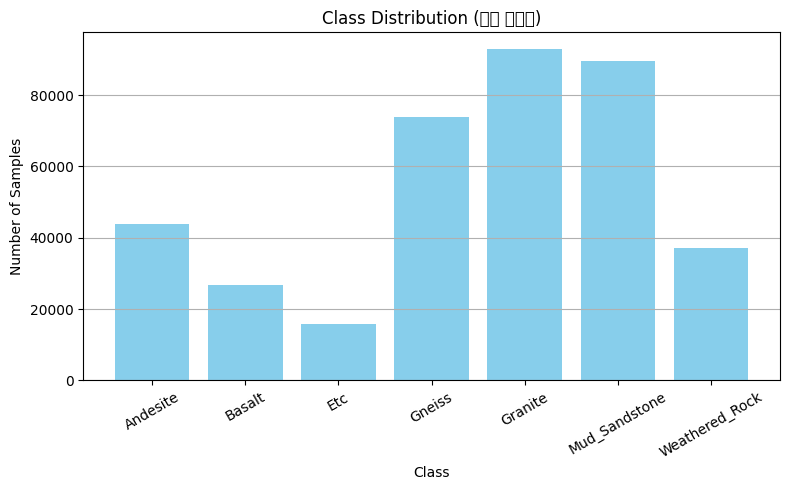

✅ Train: 342018개 / Val: 38002개


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

# 1️⃣ Transform 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# 2️⃣ ImageFolder로 전체 데이터셋 로드
dataset = ImageFolder(root="/content/gravel_data/train", transform=transform)

# 3️⃣ 클래스 이름 및 개수 자동 추출
class_names = dataset.classes
num_classes = len(class_names)
print(f"📦 클래스 수: {num_classes}")
print(f"🧷 클래스 목록: {class_names}")

# 4️⃣ 라벨 목록 추출 (stratify용)
labels = np.array(dataset.targets)

# 5️⃣ 클래스별 분포 시각화
plt.figure(figsize=(8, 5))
unique, counts = np.unique(labels, return_counts=True)
plt.bar([class_names[i] for i in unique], counts, color='skyblue')
plt.title("Class Distribution (전체 데이터)")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=30)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 6️⃣ Stratified train/val split
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size=0.1,
    stratify=labels,
    random_state=42
)

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

# 7️⃣ DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# 8️⃣ 분할 결과 출력
print(f"✅ Train: {len(train_dataset)}개 / Val: {len(val_dataset)}개")




In [ ]:
from collections import Counter

train_labels = [labels[i] for i in train_idx]
val_labels = [labels[i] for i in val_idx]

print("Train 클래스 분포:", Counter(train_labels))
print("Val 클래스 분포:", Counter(val_labels))


Train 클래스 분포: Counter({np.int64(4): 83631, np.int64(5): 80520, np.int64(3): 66523, np.int64(0): 39422, np.int64(6): 33452, np.int64(1): 24129, np.int64(2): 14341})
Val 클래스 분포: Counter({np.int64(4): 9292, np.int64(5): 8947, np.int64(3): 7391, np.int64(0): 4380, np.int64(6): 3717, np.int64(1): 2681, np.int64(2): 1594})


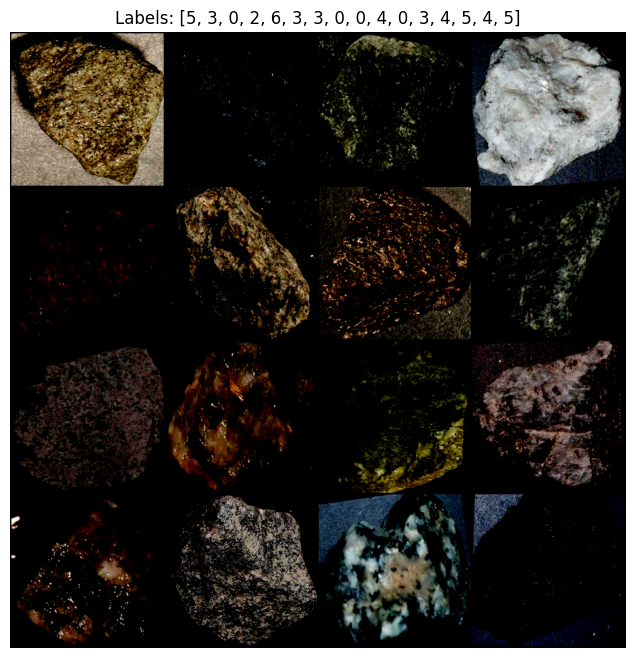

In [ ]:
import matplotlib.pyplot as plt
import torchvision

def show_batch(loader):
    images, labels = next(iter(loader))
    grid = torchvision.utils.make_grid(images[:16], nrow=4)
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f'Labels: {labels[:16].tolist()}')
    plt.show()

show_batch(train_loader)


In [ ]:
import timm
import torch.nn as nn

# DeiT 모델 불러오기
model = timm.create_model(
    'deit_base_patch16_224',
    pretrained=True,
    num_classes=7  # 자갈 클래스 수
)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)

# Cosine Annealing scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)


In [ ]:
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        correct += (outputs.argmax(dim=1) == labels).sum().item()
        total += imgs.size(0)

    acc = correct / total
    avg_loss = total_loss / total
    return avg_loss, acc


In [ ]:
from sklearn.metrics import f1_score

@torch.no_grad()
def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    avg_acc = correct / total
    macro_f1 = f1_score(all_labels, all_preds, average='macro')  # 🔥 핵심

    return avg_loss, avg_acc, macro_f1


In [ ]:
from tqdm import tqdm

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    loop = tqdm(loader, desc="Epoch Progress", leave=True)

    for inputs, labels in loop:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item(), acc=correct/total)

    avg_loss = total_loss / len(loader)
    avg_acc = correct / total
    return avg_loss, avg_acc


In [ ]:
best_val_acc = 0

for epoch in range(1, 21):
    print(f"\n[Epoch {epoch}]")

    # 🔸 학습
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)

    # 🔸 검증 (validate 함수도 train_one_epoch과 구조 유사하게 만들어야 함)
    val_loss, val_acc = validate_2(model, val_loader, criterion, device)

    # 🔸 스케줄러
    scheduler.step()

    print(f"  Train  - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"  Val    - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # 🔸 모델 저장
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "/content/drive/MyDrive/자갈 train 및 test 사진/best_deit_base.pth")
        print("✅ Best model saved!")




[Epoch 1]


NameError: name 'train_one_epoch' is not defined

In [ ]:
!pip install scikit-learn

In [ ]:
import torch
import timm
import torch.nn as nn

# 클래스 수 (자갈 데이터셋 기준)
num_classes = 7

# 1️⃣ 모델 구조 재정의 (이전과 완전히 일치해야 함)
model = timm.create_model(
    'deit_base_patch16_224',
    pretrained=False,               # 체크포인트에서 불러올 거라 False
    num_classes=num_classes
)

# 2️⃣ GPU 할당
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 3️⃣ 저장된 모델 가중치 불러오기
checkpoint_path = "/content/drive/MyDrive/자갈 train 및 test 사진/best_deit_base.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

print("✅ 저장된 DeiT 모델 가중치 로드 완료!")



In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# (선택) epoch 수 조정
start_epoch = 1  # 이전에 6까지 했으니까 7부터
end_epoch = 20


In [ ]:
for epoch in range(start_epoch, end_epoch + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_f1 = validate(model, val_loader, criterion, device)
    scheduler.step()

    print(f"[Epoch {epoch}]")
    print(f"  Train  - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"  Val    - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, Macro F1: {val_f1:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "/content/drive/MyDrive/checkpoints/best_model.pth")
        print("✅ Best model saved!")


In [ ]:
#EDA, data analytics, dataset class, going into training loop,
#inference part, post processing analysis(confusion matrix), classification at scale